In [1]:
using Pkg; Pkg.build()

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/b19db3927f0db4151cb86d073689f2428e524576/build.log`
    Building IJulia → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/cb6d2b1dc4dc12ce8589511f2307a69fe39a028e/build.log`
Precompiling packages...
   1827.2 ms  ✓ LinearSolve → LinearSolveEnzymeExt
   2195.8 ms  ✓ LinearSolve → LinearSolveKernelAbstractionsExt
   3026.2 ms  ✓ BracketingNonlinearSolve
   3866.7 ms  ✓ LinearSolve → LinearSolveSparseArraysExt
   1245.0 ms  ✓ BracketingNonlinearSolve → BracketingNonlinearSolveForwardDiffExt
   5834.8 ms  ✓ NonlinearSolveSpectralMethods
   1201.0 ms  ✓ BracketingNonlinearSolve → BracketingNonlinearSolveChainRulesCoreExt
   7542.8 ms  ✓ SimpleNonlinearSolve
   2052.5 ms  ✓ NonlinearSolveSpectralMethods → NonlinearSolveSpectralMethodsForwardDiffExt
  13274.3 ms  ✓ NonlinearSolveQuasiNewton
   1567.5 ms  ✓ SimpleNonlinearSolve → SimpleNonlinearSolveChainRulesCoreExt
   2593.0 ms  ✓ NonlinearSolveQu

In [2]:
#=
Pkg.add("Plots")
Pkg.add("Sobol")
Pkg.add("StatsBase")
Pkg.add("StatsFuns")
Pkg.add("PythonCall")
=#

In [2]:
using SciBmad 
using Plots
using Sobol, StatsBase
using StatsFuns: norminvcdf

In [3]:
include("nsrl.jl")

In [4]:
# Generate Sobol uniforms in (0,1)^d
function sobol_uniform(n::Int, d::Int)
    seq = SobolSeq(d)
    U = Array{Float64}(undef, n, d)
    for i in 1:n
        U[i, :] = next!(seq)    # each is in [0,1)
    end
    return U
end

# Map to standard normals elementwise via probit (inverse CDF)
function sobol_normals(n::Int, d::Int; eps::Float64 = 1e-12)
    U = sobol_uniform(n, d)
    clamp!(U, eps, 1 - eps)     # avoid 0 or 1 -> ±Inf after inverse-CDF
    return norminvcdf.(U)       # elementwise inverse CDF
    # alternatively:
    # return quantile.(Normal(), U)
    # return sqrt(2) .* erfinv.(2 .* U .- 1)
end

sobol_normals (generic function with 1 method)

In [5]:
# Use 4 dims: 2 for x-plane, 2 for y-plane
N = 50_000
Z = sobol_normals(N, 4)
Zx = Z[:, 1:2]
Zy = Z[:, 3:4]

epsilon_a = 7.7e-6
epsilon_b = 7.7e-6

beta_a = 7
beta_b = 8
alpha_a = -0.3
alpha_b = -0.8


Mx = [sqrt(beta_a) 0; -alpha_a/sqrt(beta_a) 1/sqrt(beta_a)]
My = [sqrt(beta_b) 0; -alpha_b/sqrt(beta_b) 1/sqrt(beta_b)]


coords_x = sqrt(epsilon_a) .* (Zx * Mx')
coords_y = sqrt(epsilon_b) .* (Zy * My')
coords_z = zeros(N, 2)

coords = hcat(coords_x, coords_y, coords_z)
b0 = Bunch(coords, species = Ta, R_ref = R)

bunch = deepcopy(b0);

In [344]:
include("helpers.jl")

hist

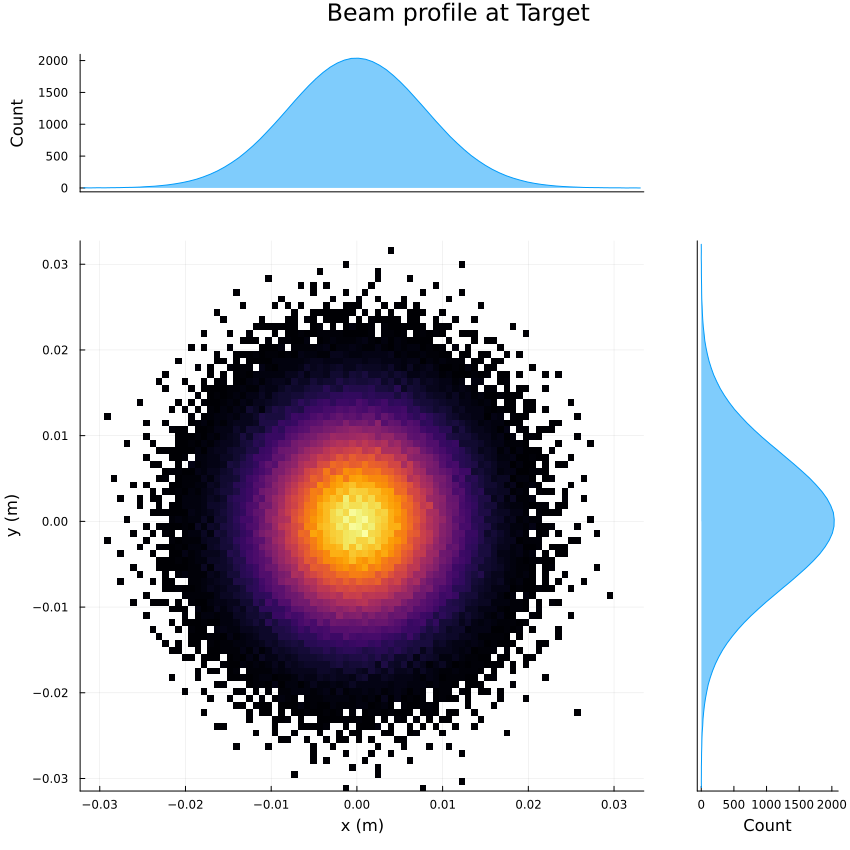

In [345]:
hist(bunch, nx=80, ny=80, xlims=nothing, ylims=nothing, make_plot=true, cutout=false)["figure"]

In [346]:
track!(bunch, nsrl);

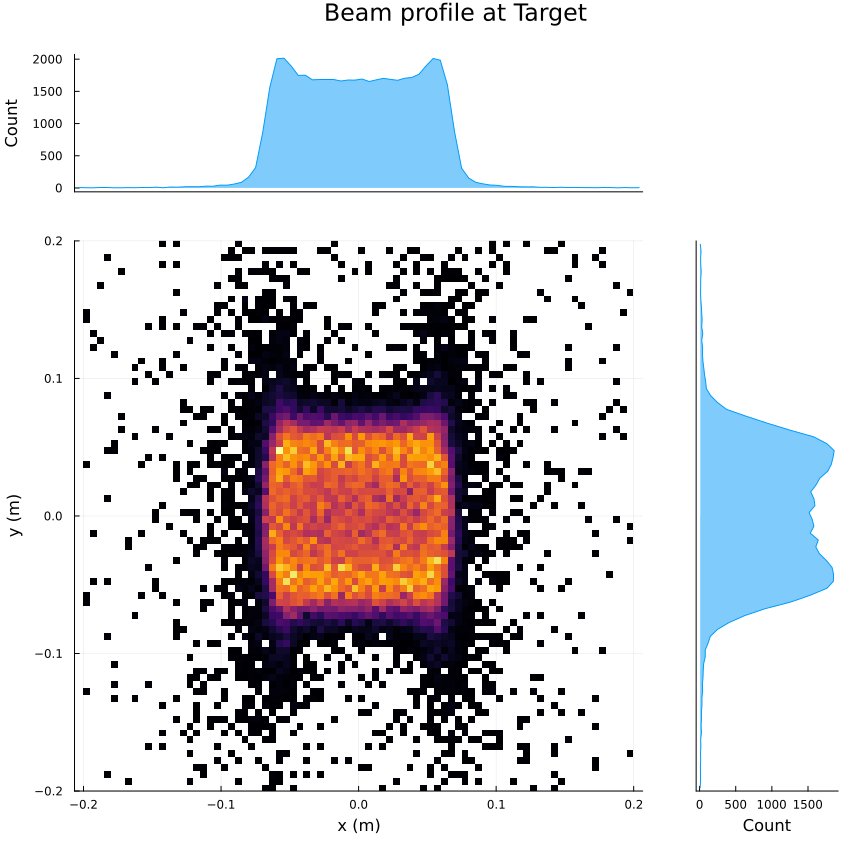

In [347]:
hist(bunch, nx=80, ny=80)["figure"]

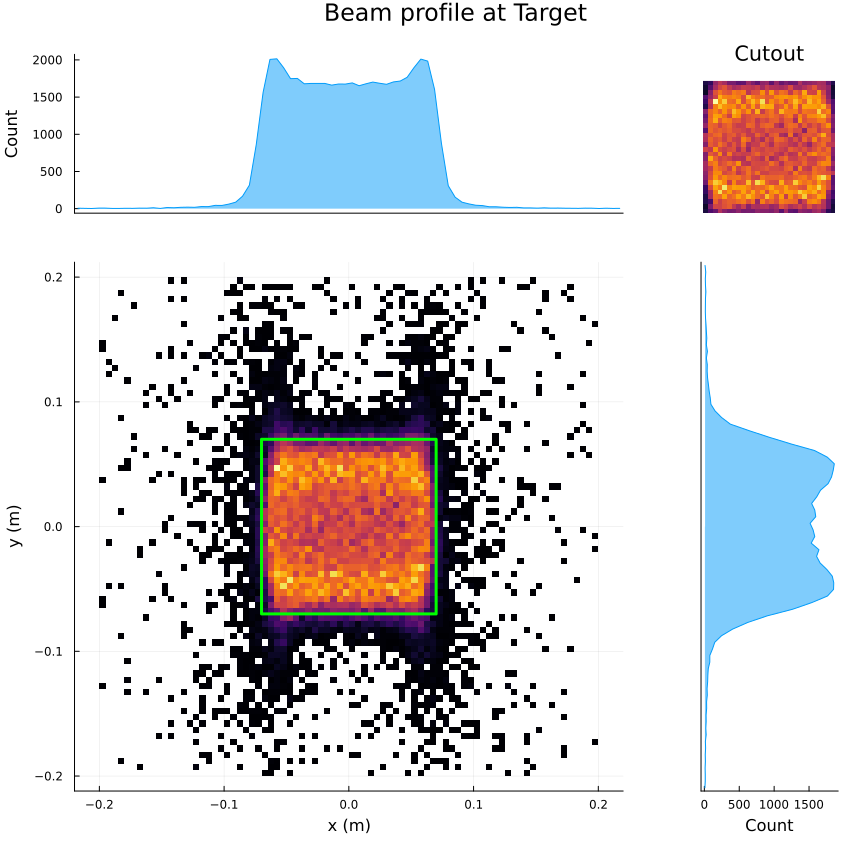

In [348]:
p0 = hist(
    bunch, 
    nx=80, ny=80,
    h=0.07, v=0.07,
    cutout=true
)["figure"]

In [284]:
cutout = hist(
    bunch, 
    nx=80, ny=80,
    h=0.05, v=0.05,
    cutout=true,
    make_plot=false
)

Dict{String, Any} with 7 entries:
  "n_total"   => 50000
  "y_centers" => -0.1975:0.005:0.1975
  "x_edges"   => -0.2:0.005:0.2
  "x_centers" => -0.1975:0.005:0.1975
  "cutout"    => [65.0 73.0 … 72.0 77.0; 89.0 69.0 … 75.0 71.0; … ; 72.0 69.0 ……
  "y_edges"   => -0.2:0.005:0.2
  "center"    => (0.0, 0.0)

In [285]:
cutout_hist = cutout["cutout"]
n_particles = cutout["n_total"]

println("Portion of total: ", sum(cutout_hist) / n_particles * 100, " %")
println("Mean: ", round(mean(cutout_hist), digits=3))
println("STD: ", round(std(cutout_hist), digits=3))
println("Max: ", maximum(cutout_hist), "  Min: ", minimum(cutout_hist))

Portion of total: 47.666 %
Mean: 59.582
STD: 9.257
Max: 89.0  Min: 36.0


In [286]:
function box_merit(box_result)
    box_data = box_result["cutout"]
    n_total = box_result["n_total"]
    return (
        sum(box_data) / n_total,
        std(box_data) / mean(box_data)
    )
end

box_merit (generic function with 1 method)

In [287]:
box_merit( cutout )

(0.47666, 0.15536020732029798)

In [17]:
merit_size = Array{Float64}(undef, 21, 21, 3, 2)

for (i, q3_b1) in enumerate(2:0.1:4)
    Q3.Bn1 = q3_b1
    for (j, q4_b1) in enumerate(-2:-0.1:-4)
        Q4.Bn1 = q4_b1
        b_tmp = deepcopy(b0)
        track!(b_tmp, nsrl)
        for (k, _size) in enumerate(0.05:0.01:0.07)
            try
                hist_temp = hist(b_tmp, nx=80, ny=80, make_plot=false)
                merit_size[i, j, k, :] .= box_merit(box(hist_temp, h=_size, v=_size))
            catch
                merit_size[i, j, k, :] .= [NaN, NaN]
            end
        end
    end
end

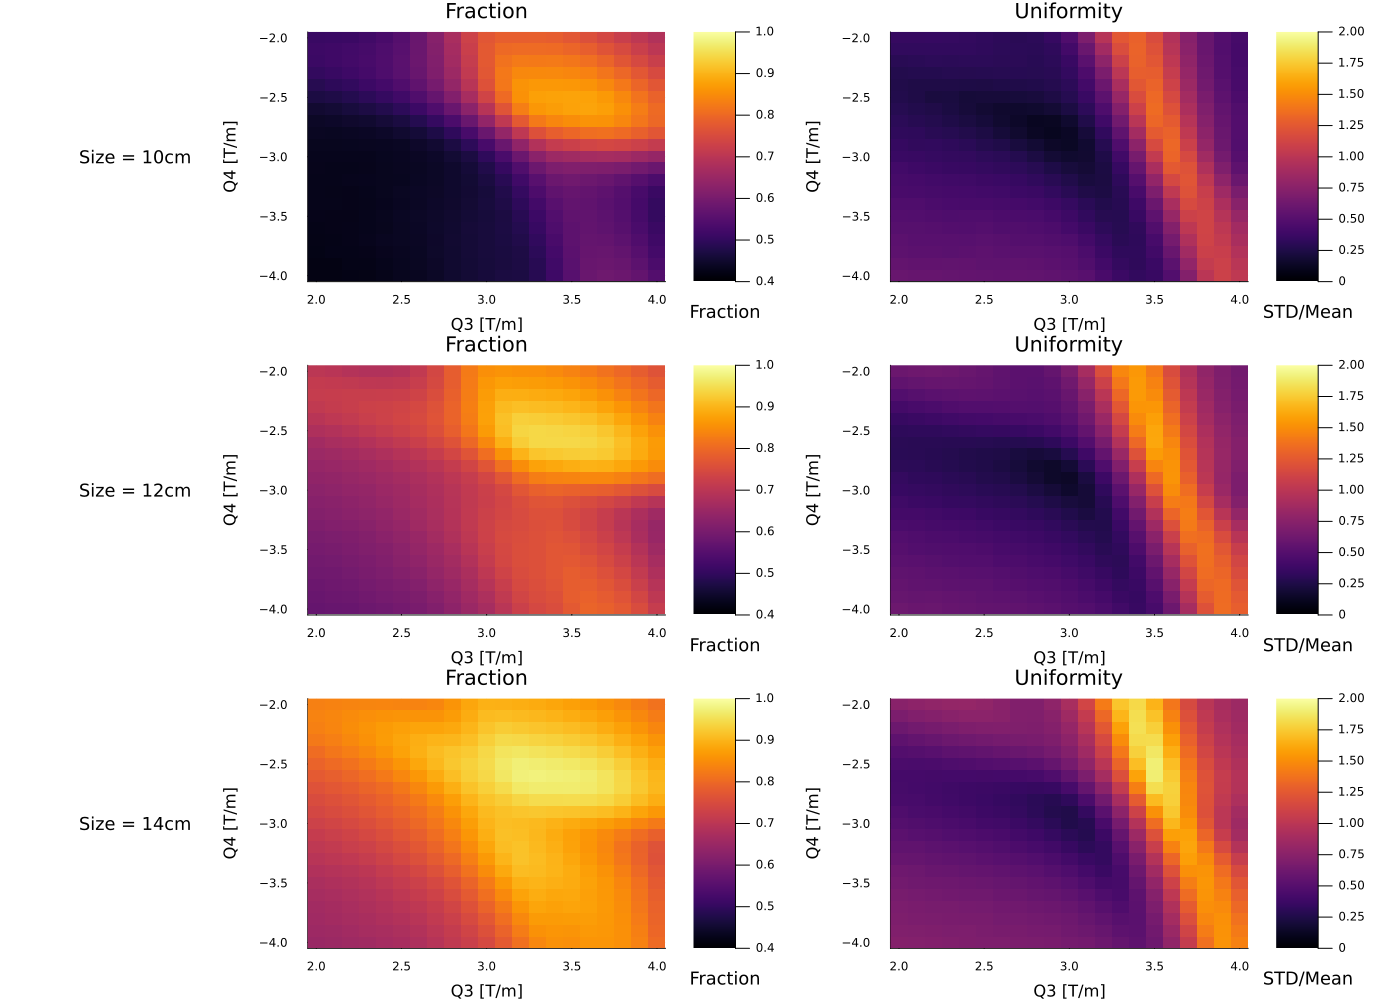

In [31]:
# Create plots for all 5 slices from the 3rd dimension
all_plots = []

for k in 1:3
    p_blank = plot(framestyle=:none, axis=false)
    annotate!(p_blank, 0.5, 0.5, text("Size = $(8+2*k)cm", :center, 12))

    p_left = heatmap(2:0.1:4, -4:0.1:-2, merit_size[:, end:-1:1, k, 1]', 
                     xlabel="Q3 [T/m]", ylabel="Q4 [T/m]", 
                     clims=(0.4, 1.0),
                     title="Fraction")
    annotate!(p_left, 4.4, -4.3, text("Fraction", :center, 12))
    
    p_right = heatmap(2:0.1:4, -4:0.1:-2, merit_size[:, end:-1:1, k, 2]', 
                      xlabel="Q3 [T/m]", ylabel="Q4 [T/m]", 
                      clims=(0.0, 2.0),
                      title="Uniformity")
    annotate!(p_right, 4.4, -4.3, text("STD/Mean", :center, 12))
    
    push!(all_plots, p_blank)
    push!(all_plots, p_left)
    push!(all_plots, p_right)
end

# Create layout with all plots: 5 rows, 3 columns with custom widths
l = grid(3, 3, heights=repeat([1/3], 3), widths=[0.15, 0.425, 0.425])
plot(all_plots..., layout=l, size=(1400, 1000))

In [39]:
merit_oct = Array{Float64}(undef, 21, 21, 5, 2)

for (i, q3_b1) in enumerate(2:0.1:4)
    Q3.Bn1 = q3_b1
    for (j, q4_b1) in enumerate(-2:-0.1:-4)
        Q4.Bn1 = q4_b1
        for (k, o_b3) in enumerate(1250:250:2250)
            O1.Bn3 = -o_b3
            O2.Bn3 =  o_b3
            b_tmp = deepcopy(b0)
            track!(b_tmp, nsrl)
            try 
                hist_data = hist(b_tmp, nx=80, ny=80, make_plot=false)
                merit_oct[i, j, k, :] .= box_merit(box(hist_data, h=0.05, v=0.05))
            catch
                println("Q3.Bn1 = ", q3_b1)
                println("Q4.Bn1 = ", q4_b1)
                println("O.Bn3  = ", o_b3)
                merit_oct[i, j, k, :] .= [NaN, NaN]
            end
        end
    end
end

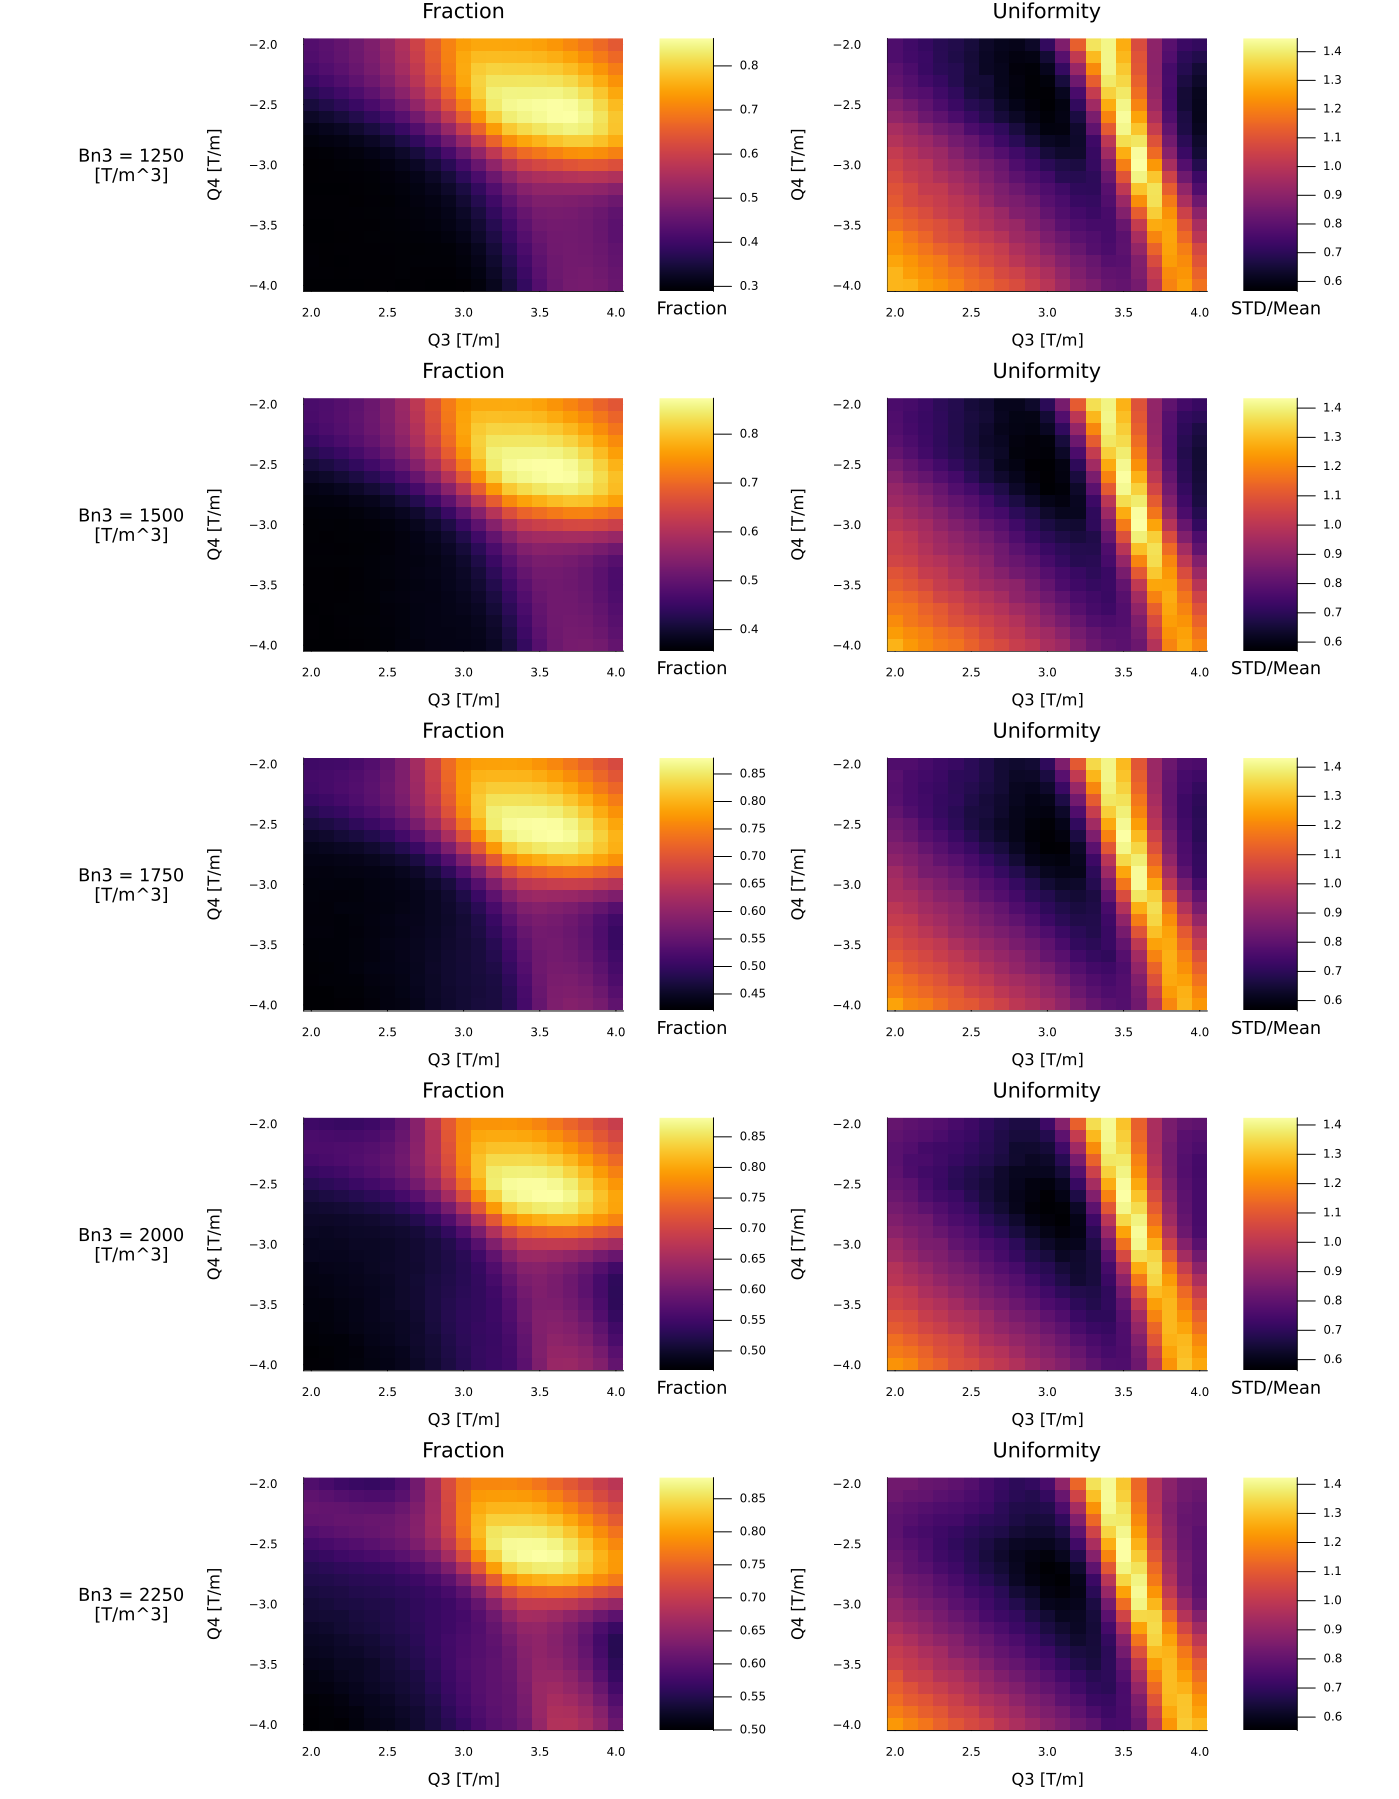

In [207]:
# Create plots for all 5 slices from the 3rd dimension
all_plots = []

for k in 1:5
    p_blank = plot(framestyle=:none, axis=false)
    annotate!(p_blank, 0.5, 0.5, text("Bn3 = $(1250+250*(k-1))\n[T/m^3]", :center, 12))

    p_left = heatmap(2:0.1:4, -4:0.1:-2, merit_oct[:, end:-1:1, k, 1]', 
                     xlabel="Q3 [T/m]", ylabel="Q4 [T/m]", 
                     title="Fraction")
    annotate!(p_left, 4.5, -1.2, text("Fraction", :center, 12))
    
    p_right = heatmap(2:0.1:4, -4:0.1:-2, merit_oct[:, end:-1:1, k, 2]', 
                      xlabel="Q3 [T/m]", ylabel="Q4 [T/m]", 
                      title="Uniformity")
    annotate!(p_right, 4.5, -1.2, text("STD/Mean", :center, 12))
    
    push!(all_plots, p_blank)
    push!(all_plots, p_left)
    push!(all_plots, p_right)
end

# Create layout with all plots: 5 rows, 3 columns with custom widths
l = grid(5, 3, heights=repeat([1/5], 5), widths=[0.15, 0.425, 0.425])
plot(all_plots..., layout=l, size=(1400, 1800))

In [288]:
ENV["JULIA_PYTHONCALL_EXE"] = joinpath(ENV["CONDA_PREFIX"], "bin", "python")

using PythonCall

xopt = pyimport("xopt")
np = pyimport("numpy")
pydict = pyimport("builtins").dict

Python: <module 'xopt' from '/Users/eiadhamwi/miniforge3/lib/python3.12/site-packages/xopt/__init__.py'>

In [289]:
Xopt = xopt.Xopt
VOCS = xopt.vocs.VOCS
Evaluator = xopt.evaluator.Evaluator
bayesian = pyimport("xopt.generators.bayesian")
ExpectedImprovementGenerator = bayesian.ExpectedImprovementGenerator

Python: <class 'xopt.generators.bayesian.expected_improvement.ExpectedImprovementGenerator'>

In [290]:
Py(Dict(
        "x1" => [ 2.0,  4.0], 
        "x2" => [-4.0, -2.0], 
        "x3" => [1250., 2250.]
        ))

Dict{String, Vector{Float64}} with 3 entries:
  "x1" => [2.0, 4.0]
  "x2" => [-4.0, -2.0]
  "x3" => [1250.0, 2250.0]

In [291]:
vocs = VOCS(
    variables = Dict(
            "x1" => [ 2.0,  4.0], 
            "x2" => [-4.0, -2.0], 
            "x3" => [1250., 2250.]
            ), 
    objectives = Dict(
            "f" => "MINIMIZE"
            )
)

Python: VOCS(variables={'x1': [2.0, 4.0], 'x2': [-4.0, -2.0], 'x3': [1250.0, 2250.0]}, constraints={}, objectives={'f': 'MINIMIZE'}, constants={}, observables=[])

In [296]:
function func(x)
    Q3.Bn1 =  x["x1"]
    Q4.Bn1 =  x["x2"]
    O1.Bn3 = -x["x3"]
    O2.Bn3 =  x["x3"]
    
    bunch_tmp = deepcopy(b0)
    track!(bunch_tmp, nsrl)
    
    cutout_tmp = hist(bunch_tmp, nx=80, ny=80, h = 0.07, v = 0.07, make_plot=false, cutout=true)
    frac, uniform = box_merit( cutout_tmp )
    
    return pydict(Dict("f" => uniform + exp(25 * (0.7 - frac))))
end

func (generic function with 1 method)

In [294]:
pydict(Dict(
        "x1" =>  3.0,
        "x2" => -3.0,
        "x3" => 1.75e3
))

Python: {'x1': 3.0, 'x2': -3.0, 'x3': 1750.0}

In [313]:
evaluator = Py(Evaluator(; :function => func))

generator = ExpectedImprovementGenerator(; :vocs => vocs, :turbo_controller => "optimize")
generator.gp_constructor.use_low_noise_prior = true

X = Xopt(; :evaluator => evaluator, :generator => generator, :vocs => vocs)

_tmp = pydict(Dict(
    "x1" =>  [3.0, 2.0, 2.0, 4.0, 4.0],
    "x2" => [-3.0, -4.0, -2.0, -2.0, -4.0],
    "x3" => [1.75e3, 1.75e3, 1.75e3, 1.75e3, 1.75e3]
))

X.evaluate_data(_tmp)

,x1,x2,x3,f,xopt_runtime,xopt_error
0,3.0,-3.0,1750.0,0.261671,0.661419,False
1,2.0,-4.0,1750.0,82455.068993,0.130564,False
2,2.0,-2.0,1750.0,5.140986,0.130764,False
3,4.0,-2.0,1750.0,15.136187,0.130402,False
4,4.0,-4.0,1750.0,13.238485,0.130890,False


In [314]:
@time for i in 1:250
    X.step()
end

135.783122 seconds (105.51 k allocations: 852.334 MiB, 0.72% gc time)


In [315]:
mask = X.data["f"] .== X.data["f"].min()
ind = X.data["f"].index[mask][0]
py_series = X.data.loc[ind]

keys = collect(py_series.index)
values = collect(py_series.values)

jl_dict = Dict(string(k) => v for (k, v) in zip(keys, values))

Dict{String, Py} with 6 entries:
  "f"            => np.float64(0.19815845769350476)
  "x1"           => np.float64(2.9805681875765178)
  "x2"           => np.float64(-2.9604655015295838)
  "xopt_error"   => np.False_
  "x3"           => np.float64(1459.509896059617)
  "xopt_runtime" => np.float64(0.13029541599098593)

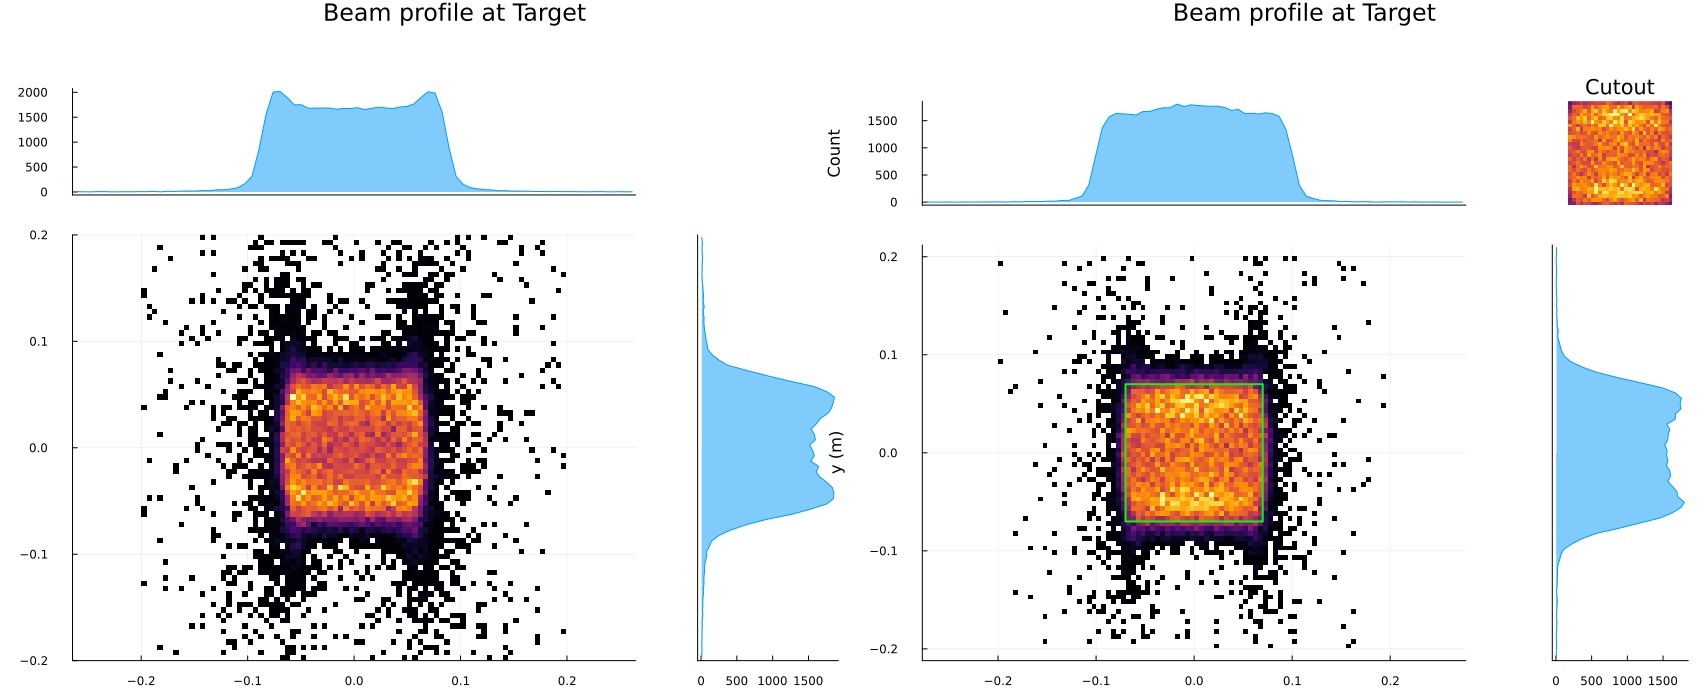

In [333]:
#println(box_merit(box(h = 0.07, v = 0.07)))

Q3.Bn1 =  pyconvert(Float64, jl_dict["x1"]) #2.967012114407703 
Q4.Bn1 =  pyconvert(Float64, jl_dict["x2"]) #-2.95254862450049 
O1.Bn3 = -pyconvert(Float64, jl_dict["x3"]) #-1490.8026736329402 
O2.Bn3 =  pyconvert(Float64, jl_dict["x3"]) #1490.8026736329402 

#println(box_merit(box(h = 0.07, v = 0.07)))
b_tmp = deepcopy(b0)
track!(b_tmp, nsrl)
p_tmp = hist(b_tmp, nx=80, ny=80, cutout=true, h=0.07, v=0.07);

plot(p0["figure"], p_tmp["figure"], size=(1700, 700))